In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from DataLoader import HeartFailureDataset
import matplotlib.colors as colors
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import random
from random import sample

random.seed(42) 

X = pd.read_pickle("X.pkl")
feauture_names = list(X.columns)
y = pd.read_pickle("y.pkl")
print(feauture_names)

['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking']


Since we want to compare different models and require various input formats, we preprocess our data:
- convert to `np.arrays`
- create y vectors with classes `{0, 1}` and `{-1, 1}`


In [141]:
X = np.array(X)
y_zero_one = y['death_event'].to_numpy()
print(y_zero_one)
y_ones = np.where(y == 0, -1, 1)


[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


We want to train an SVM ourselves and apply methods from the lecture.  
We attempt to use the Banach Fixed-Point Theorem and aim to find a minimum through gradient descent.  
We use a Soft Margin SVM with hinge loss, resulting in the following convex loss function:  
$$  
\mathcal{L}(w, b) = \frac{1}{2} \|w\|^2 + C \cdot \frac{1}{n} \sum_{i=1}^n \max\left(0,\ 1 - y_i \cdot (x_i^\top w + b)\right)  
$$


In [142]:
def gradient_descent(f, f_gradient, f_hessian, x_0, step_size, max_iter, eps=1e-1):
    d = x_0.shape[0]
    thetas = np.zeros((max_iter,d))
    thetas[0] = x_0

    for i in range(1, max_iter):
        grad = np.squeeze(f_gradient(thetas[i-1]))
        step = step_size(i-1) if callable(step_size) else step_size
        theta_next = thetas[i-1] - step * grad
        thetas[i] = theta_next
        if np.sum(grad**2) < eps*eps:
            break
    return thetas[:i+1]

def hinge_loss(t):
    return np.maximum(0, 1 - t)

def hinge_gradient(t):
    return (t < 1).astype(float) * -1

def svm_loss(w, b, C, x, y):
    loss = 0.5*np.sum(w**2, axis=0) + C/x.shape[0] * np.sum(hinge_loss(y*(np.matmul(x, w) + b)), axis=0)
    print(loss)
    return loss

def svm_gradient(w, b, C, x, y):
    n, d = x.shape
    if w.ndim == 1:
        m = 1
    else:
        m = w.shape[1]
        if isinstance(b, np.ndarray):
            b = b.reshape(1, m) 
    w = w.reshape(d, m)
    y = y.reshape(n, 1)
    w_bar = w + C/n * np.einsum('nm,nd->dm', hinge_gradient(y*(np.matmul(x, w) + b)), y*x)
    b_bar = C/n * np.sum(hinge_gradient(y*(np.matmul(x, w) + b))*y, axis=0, keepdims=True)
    return np.concatenate([w_bar, b_bar], axis=0).squeeze()



class SVM_GD(BaseEstimator, ClassifierMixin):
    def __init__(self, bias=True, C=1,step_size=0.01, max_iter=1000):
        super(SVM_GD, self).__init__()
        
        self.bias = bias
        self.C = C
        self.step_size = step_size
        self.max_iter = max_iter
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_features = X.shape[1]

        # Initialisiere Startpunkt: w + b zusammen
        w_0 = np.zeros(n_features + 1)

        # Definiere Loss- und Gradientenfunktionen für Optimierung
        f = lambda w: svm_loss(w[:-1], w[-1], self.C, X, y)
        f_grad = lambda w: svm_gradient(w[:-1], w[-1], self.C, X, y)

        # Starte Gradientenabstieg
        trace = gradient_descent(f, f_grad, None, w_0, step_size=self.step_size, max_iter=self.max_iter)

        # Gewichte und Bias extrahieren aus letztem Punkt der Optimierung
        self.w = trace[-1, :-1]
        self.b = trace[-1, -1] if self.bias else 0
        #print(svm_loss(self.w, self.b, self.C,X,y))
        
        return trace
        
    def predict(self, X):
        if self.w is None or self.b is None:
            raise ValueError('Predict can only be called after supplying training data with fit first!')
        return np.matmul(X, self.w) + self.b
    
class SVM_SGD(SVM_GD):
    def __init__(self, bias=True, batch_size=32, C=1, step_size=0.01, max_iter=250):
        super(SVM_SGD, self).__init__(bias, C, step_size, max_iter)
        
        self.batch_size = batch_size
    
    def fit(self, X, y):
        n_features = X.shape[1]

        # Initialisiere Startpunkt: w + b zusammen
        w_0 = np.zeros(n_features + 1)

        # Definiere Loss- und Gradientenfunktionen für Optimierung
        f = lambda w: svm_loss(w[:-1], w[-1], self.C, X, y)
        
        indices = sample(range(0, X.shape[0]), self.batch_size, )
        f_grad = lambda w: svm_gradient(w[:-1], w[-1], self.C, X[indices], y[indices])
        # Starte Gradientenabstieg
        trace = gradient_descent(f, f_grad, None, w_0, step_size=self.step_size, max_iter=self.max_iter)

        # Gewichte und Bias extrahieren aus letztem Punkt der Optimierung
        self.w = trace[-1, :-1] # wähle letzten Gewichte in SGD, , das sind w1 und w2, die letzte Spalte b, wird nicht mitgenommen
        self.b = trace[-1, -1] if self.bias else 0 # Elment ganz unten rechts

        return trace
    def predict(self, X):
        if self.w is None or self.b is None:
            raise ValueError('Predict can only be called after supplying training data with fit first!')
        return np.matmul(X, self.w) + self.b

We now examine different regularization strategies by varying the constant $C$ in the loss function:
- The larger $C$, the more importance is placed on correctly classifying the training data.
- The smaller $C$, the more weight is given to the regularization term.

We evaluate our models for different values of $C$ using cross-validation and use the AUC (Area Under the Curve) as a performance metric. The AUC represents the area under the ROC curve (True Positive Rate versus False Positive Rate).

Below, we illustrate how the AUC scores behave for different levels of regularization in a linear SVM.


Bestes C: 0.07896522868499717


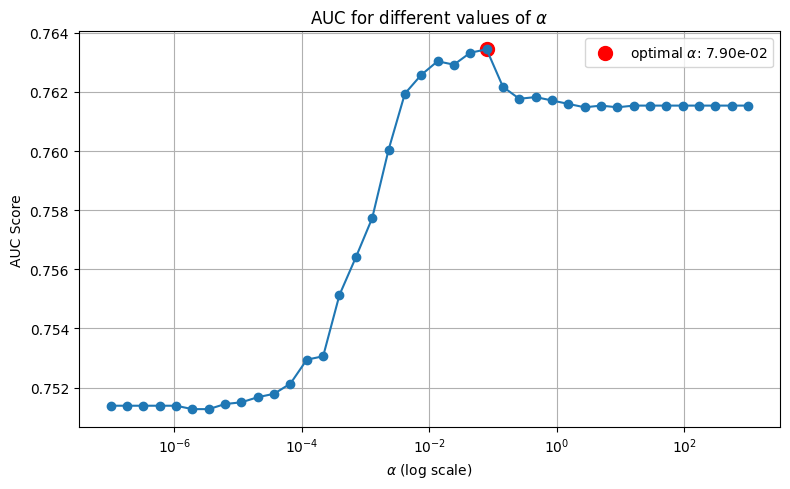

In [143]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from DataLoader import HeartFailureDataset
import matplotlib.colors as colors
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_auc_score
from random import sample
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

C_values = np.logspace(-7, 3, 40)
scores = []
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=14)

for C in C_values:
    clf = LinearSVC(C=C)
    decision_scores = cross_val_predict(clf, X, y_zero_one, cv=cv, method='decision_function')
    score = roc_auc_score(y_zero_one, decision_scores)
    scores.append(score)

best_C = C_values[np.argmax(scores)]
print("Bestes C:", best_C)

best_idx = np.argmax(scores)

plt.figure(figsize=(8, 5))
plt.plot(C_values, scores, marker='o', linestyle='-')
plt.scatter(C_values[best_idx], scores[best_idx], color='red', s=100, label=f'optimal $\\alpha$: {best_C:.2e}')
plt.xscale('log')
plt.xlabel('$\\alpha$ (log scale)')
plt.ylabel('AUC Score')
plt.title('AUC for different values of $\\alpha$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The ROC curve for the "best" $C$ is plotted below:

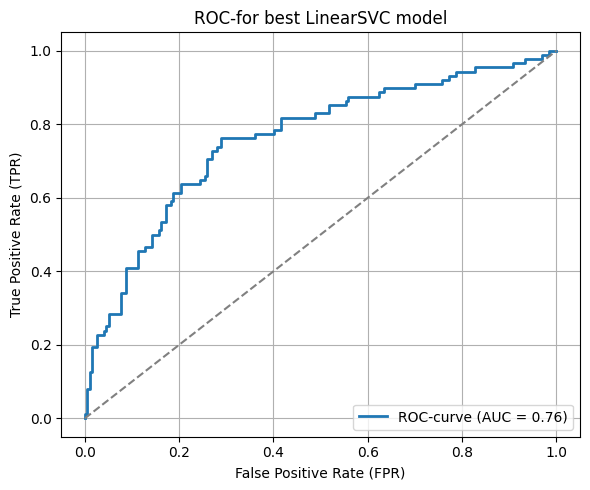

In [144]:
clf = LinearSVC(C=C)
decision_scores = cross_val_predict(clf, X, y_zero_one, cv=cv, method='decision_function')
overall_best_score = roc_auc_score(y_zero_one, decision_scores)

from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_zero_one, decision_scores)

# AUC-Wert berechnen
auc = roc_auc_score(y_zero_one, decision_scores)

# Plot der ROC-Kurve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC-curve (AUC = {auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-for best LinearSVC model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In the following, we aim to evaluate different SVM variants with respect to their numerical optimization approaches and kernel structures. We compare our own implementation of an SVM using the hinge loss with:

- **a)** Gradient Descent  
- **b)** Stochastic Gradient Descent  

and the scikit-learn implementations of:

- **c)** `LinearSVC` (linear SVM with liblinear optimizer)  
- **d)** `SVC` with a **Gaussian (RBF) kernel**  
- **e)** `SVC` with a **polynomial kernel**

The goal is to investigate differences in model quality, runtime, and convergence behavior.



Starte Evaluierung: linear kernel GD
linear kernel GD Nested CV mittlere AUC: 0.7485 ± 0.1083
linear kernel GD mittlere Laufzeit: 0.01 Sekunden

Starte Evaluierung: linear SVM (SGD)
linear SVM (SGD) Nested CV mittlere AUC: 0.6973 ± 0.1053
linear SVM (SGD) mittlere Laufzeit: 0.00 Sekunden

Starte Evaluierung: linear SVM (sklearn)
linear SVM (sklearn) Nested CV mittlere AUC: 0.7584 ± 0.1140
linear SVM (sklearn) mittlere Laufzeit: 0.01 Sekunden

Starte Evaluierung: rbf kernelized SVM
rbf kernelized SVM Nested CV mittlere AUC: 0.7790 ± 0.0841
rbf kernelized SVM mittlere Laufzeit: 0.01 Sekunden

Starte Evaluierung: poly kernelized SVM
poly kernelized SVM Nested CV mittlere AUC: 0.7043 ± 0.0679
poly kernelized SVM mittlere Laufzeit: 0.01 Sekunden
Train Accuracy: [0.7734375, 0.76953125, 0.765625, 0.75, 0.77734375, 0.7665369649805448, 0.7704280155642024, 0.7976653696498055, 0.7898832684824902, 0.7821011673151751]
Train ROC: [np.float64(0.7966816849030965), np.float64(0.8056211113494957), np.f

C:\Users\User\AppData\Local\Temp\ipykernel_25416\1661373050.py:128: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(outer_scores_all, labels=model_names, patch_artist=True)
C:\Users\User\AppData\Local\Temp\ipykernel_25416\1661373050.py:135: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(run_times_all, labels=model_names, patch_artist=True)


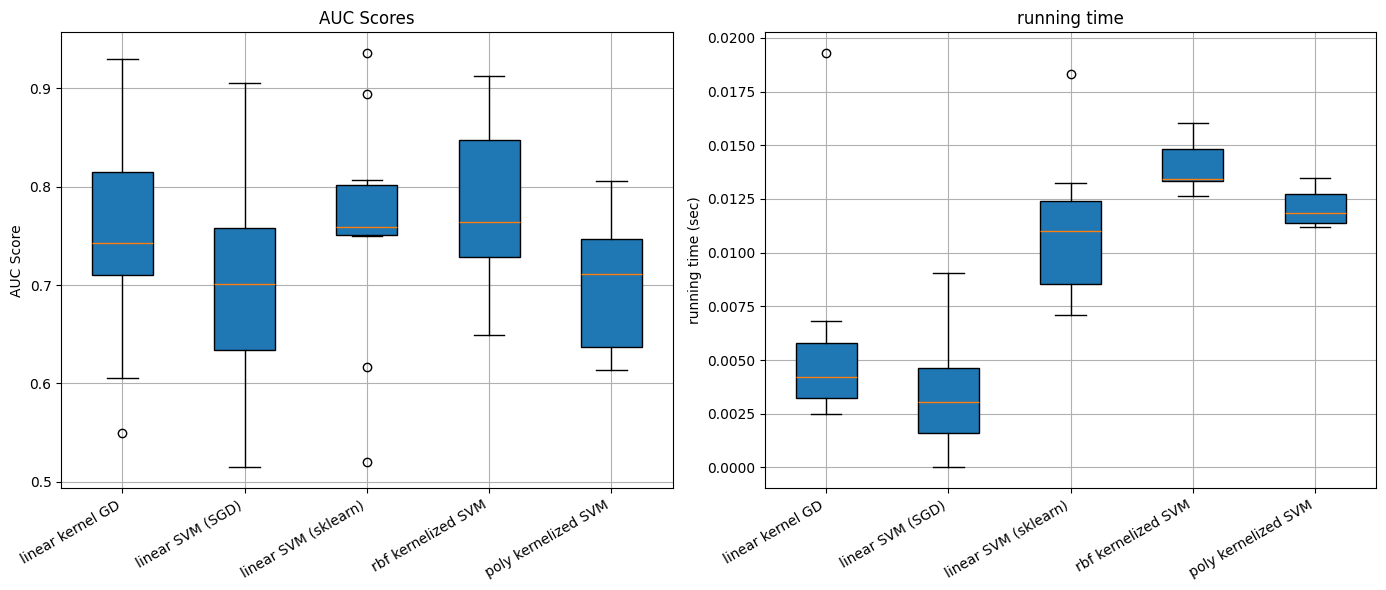

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

In [149]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

C_values = np.logspace(-4, 3, 10)
param_grid = {'C': C_values}  # Für SVC
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

models = [
    ("linear kernel GD", SVM_GD(bias=True, step_size=lambda t: 1/(t+1))),  # fixe alpha
    ("linear SVM (SGD)", SVM_SGD(bias=True, batch_size=30, step_size=lambda t: 1/(t+1))),
    ("linear SVM (sklearn)", LinearSVC()),
    ("rbf kernelized SVM", SVC(kernel='rbf')),
    ("poly kernelized SVM", SVC(kernel='poly'))
]

outer_scores_all = []
run_times_all = []
model_names = []
accuracy_all = []

acc_train_lk = []
roc_train_lk = []
acc_test_lk = []
roc_test_lk = []
run_time_lk = []

for name, model in models:
    print(f"\nStarte Evaluierung: {name}")
    outer_scores = []
    run_times = []
    accuracy = []

    # Für linear kernel extra Listen initialisieren
    if name == "linear SVM (sklearn)":
        acc_train = []
        roc_train = []
        acc_test = []
        roc_test = []
        run_times_model = []

    for train_idx, test_idx in outer_cv.split(X, y_zero_one):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y_zero_one[train_idx], y_zero_one[test_idx]
        y_train_ones, y_test_ones = y_ones[train_idx], y_ones[test_idx]


        if isinstance(model, SVC) or isinstance(model, LinearSVC):
            start_time = time.time()
            grid = GridSearchCV(model, param_grid, cv=inner_cv, scoring='roc_auc', n_jobs=1)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            
            elapsed = time.time() - start_time
            run_times.append(elapsed / len(C_values))

            # Vorhersagen für Testdaten
            y_score_test = best_model.decision_function(X_test)
            auc_test = roc_auc_score(y_test, y_score_test)
            outer_scores.append(auc_test)
            y_pred_test = (y_score_test > 0).astype(int)
            acc_test_fold = accuracy_score(y_test, y_pred_test)
            accuracy.append(acc_test_fold)

            # Vorhersagen für Trainingsdaten (für Training-Metriken)
            y_score_train = best_model.decision_function(X_train)
            auc_train = roc_auc_score(y_train, y_score_train)
            y_pred_train = (y_score_train > 0).astype(int)
            acc_train_fold = accuracy_score(y_train, y_pred_train)

            # Für "linear kernel" abspeichern
            if name == "linear SVM (sklearn)":
                acc_train.append(acc_train_fold)
                roc_train.append(auc_train)
                acc_test.append(acc_test_fold)
                roc_test.append(auc_test)
                run_times_model.append(elapsed)

        else:
            start_time = time.time()
            # Für andere Modelle (z.B. selbst implementiert)
            model.fit(X_train, y_train_ones)
            best_model = model
            elapsed = time.time() - start_time
            run_times.append(elapsed)

            y_score_test = best_model.predict(X_test)
            y_score_test = (y_score_test + 1) / 2
            auc_test = roc_auc_score(y_test, y_score_test)
            outer_scores.append(auc_test)

    outer_scores_all.append(outer_scores)
    run_times_all.append(run_times)
    model_names.append(name)

    if name == "linear SVM (sklearn)":
        # Gesamtergebnis speichern
        accuracy_all.append(accuracy)  # Accuracy Testdaten
        scores_lk = outer_scores  # ROC Testdaten
        accuracy_lk = accuracy
        acc_train_lk = acc_train
        roc_train_lk = roc_train
        acc_test_lk = acc_test
        roc_test_lk = roc_test
        run_time_lk = run_times_model

    print(f"{name} Nested CV mittlere AUC: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")
    print(f"{name} mittlere Laufzeit: {np.mean(run_times):.2f} Sekunden")

# Danach kannst du die Listen für "linear kernel" nutzen:
print("Train Accuracy:", acc_train_lk)
print("Train ROC:", roc_train_lk)
print("Test Accuracy:", acc_test_lk)
print("Test ROC:", roc_test_lk)
print("Laufzeiten:", run_time_lk)

# Visualisierung
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.boxplot(outer_scores_all, labels=model_names, patch_artist=True)
plt.ylabel("AUC Score")
plt.title("AUC Scores")
plt.xticks(rotation=30, ha='right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot(run_times_all, labels=model_names, patch_artist=True)
plt.ylabel("running time (sec)")
plt.title("running time")
plt.xticks(rotation=30, ha='right')
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))

In [150]:
model_evaluation = pd.DataFrame({"Fold": range(1, 11)})
model_evaluation['Modell'] = ['linear SVM'] * 10
model_evaluation['ROC AUC'] = roc_test_lk
model_evaluation['Accuracy'] = acc_test_lk
model_evaluation["runtime"] = run_times_model
model_evaluation

,Fold,Modell,ROC AUC,Accuracy,runtime
0,1,linear SVM,0.761111,0.827586,0.123693
1,2,linear SVM,0.788889,0.793103,0.122452
2,3,linear SVM,0.894444,0.793103,0.074071
3,4,linear SVM,0.616667,0.724138,0.070849
4,5,linear SVM,0.750000,0.758621,0.088581
5,6,linear SVM,0.935673,0.750000,0.132436
6,7,linear SVM,0.754386,0.821429,0.084055
7,8,linear SVM,0.520468,0.571429,0.097998
8,9,linear SVM,0.806250,0.678571,0.183256
9,10,linear SVM,0.756250,0.678571,0.124446


In [151]:
model_evaluation.to_pickle('model_evaluation/LinearSVM.pkl')

Next we want to take a look at feature importance. Therefore we do nested crossvalidateion and try to predict permuted data in each feature. The loss in AUC value gives an idea of the feature importance of current observed feature.
Vergehen: Für jeden Outer Fold, mit dem durch Inner CV erkanntem besten Parameter das modell fitten und dann für jedes Feature permutieren und erneut AUC bestimmen, dann erhalte ich wieder 10 werte für AUC für jedes Feature.


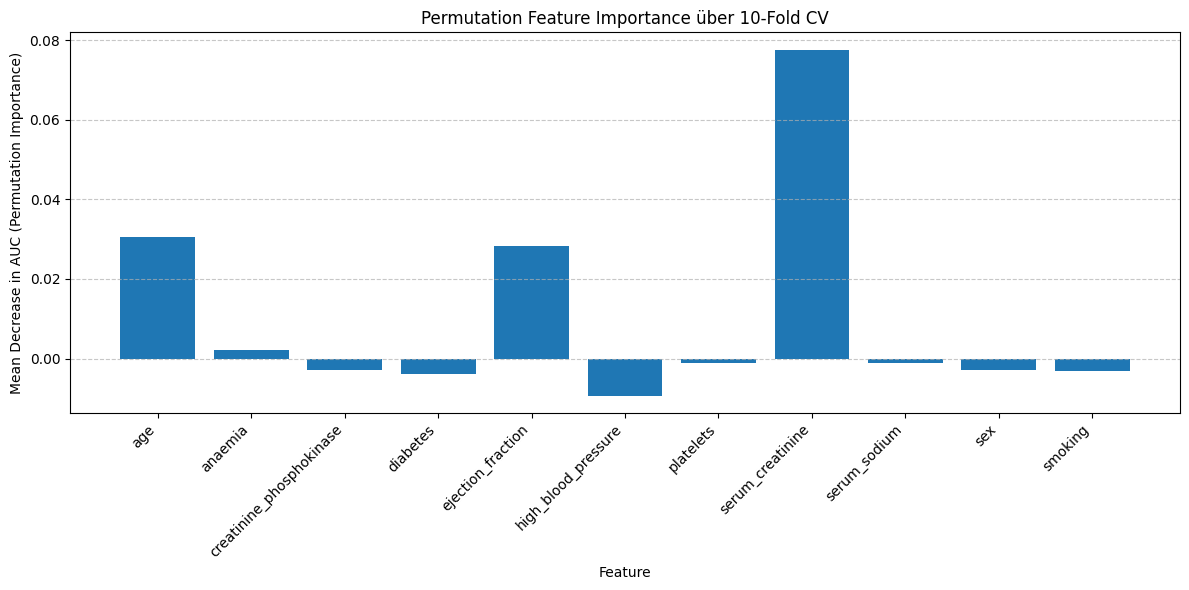

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from collections import defaultdict

C_values = np.logspace(-4, 3, 10)
param_grid = {'C': C_values}  # Für SVC
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


def model_fitting(X, y, feauture_names):
    C_values = np.logspace(-4, 3, 10)
    param_grid = {'C': C_values}
    outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    outer_scores = []
    perm_importances = defaultdict(list)  # feature index -> list of AUC drops
    
    base_model = SVC(kernel='linear', probability=True, random_state=42)
    
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        grid = GridSearchCV(base_model, param_grid, cv=inner_cv, scoring='roc_auc', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        
        # Baseline AUC auf Testdaten
        y_score_test = best_model.decision_function(X_test)
        auc_baseline = roc_auc_score(y_test, y_score_test)
        outer_scores.append(auc_baseline)
        
        # Permutation Feature Importance (AUC-Drop)
        for i in range(X_test.shape[1]):
            X_test_permuted = X_test.copy()
            X_test_permuted[:, i] = np.random.permutation(X_test_permuted[:, i])
            y_score_perm = best_model.decision_function(X_test_permuted)
            auc_perm = roc_auc_score(y_test, y_score_perm)
            perm_importances[i].append(auc_baseline - auc_perm)  # Unterschied AUC
    
    # Durchschnittliche Importance pro Feature über alle Folds
    mean_importances = np.array([np.mean(perm_importances[i]) for i in range(X.shape[1])])
    std_importances = np.array([np.std(perm_importances[i]) for i in range(X.shape[1])])
    
    # Visualisierung
    plt.figure(figsize=(12, 6))
    plt.bar(feauture_names, mean_importances)#, yerr=std_importances, capsize=5)
    plt.xlabel('Feature')
    plt.ylabel('Mean Decrease in AUC (Permutation Importance)')
    plt.title('Permutation Feature Importance über 10-Fold CV')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')  # Dreht die Namen für bessere Lesbarkeit
    plt.tight_layout()  # Verhindert Überschneidungen
    plt.show()
    
    return outer_scores, mean_importances

# Beispiel-Aufruf:
outer_scores, feature_importances = model_fitting(X, y_zero_one, feauture_names)


In [ ]:
df_feature_selection = pd.DataFrame({
    'Feature': feauture_names,
    'average decrease in AUC': feature_importances
})
df_feature_selection
df_feature_selection.to_pickle('feature_importance/LinearSVM.pkl')